In [5]:

from google.colab import drive
drive.mount('/content/drive')

root_path = '/content/drive/MyDrive/CVDL'
dumps_path =  f"{root_path}/dumps/"
dataset  = f"{root_path}/dataset/"

!cp "$root_path/modules/lib.py" .
!cp "$root_path/modules/plots.py" .
!cp "$root_path/modules/metrics.py" .


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing

## Imports

In [6]:
import cv2
import pickle
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import importlib
from datetime import datetime

from keras.initializers import glorot_uniform

import lib
import plots
import metrics

tf.keras.backend.clear_session()

## Parameters

In [7]:
# Deafault Res: 606x468 (ar 101 : 78)

# Tested Res's:
# 224x160 (ar 7 : 5)
# 384x288
# 576x432
# 512x384
input_res = (384, 288)

seed = 42

params = {
          'x':input_res[0],                                
          'y':input_res[1],                                
          'batch_size': 8,                        
          'n_channels_mask': 1,                            
          'n_channels': 1,                        
          'shuffle': True,              
          'learningRate': 1e-3,                       
          'nEpoches': 100,                        
          }

ratio_test = 0.85
ratio_val  = 0.8

lib.create_dump([params, seed], dumps_path + "params_du")

type_ds  = ['Images','Masks']
modality = ['train','validation','test']

# get path Img and Mask
path_img  = os.path.join(dataset, type_ds[0])
path_msk  = os.path.join(dataset, type_ds[1])
path_     = [path_img, path_msk]

# get length imgs and proof that is equal with masks
length_imgs  = len(os.listdir(os.path.join(dataset,type_ds[0] + "/"))) 
length_masks = len(os.listdir(os.path.join(dataset,type_ds[1] + "/")))
params['length_data'] = length_imgs,

# get name of file imgs
imgs_list_path = os.listdir(path_img)

## Data loading 

In [8]:
# LOAD & SPLIT DATA ============================================================
'''
mode = 1  # mode = 0: Random Split
          # mode = 1: Split for Patients
          
dataset_list = lib.get_dataset_list(
                                mode, 
                                path_, 
                                imgs_list_path, 
                                params, 
                                ratio_test, 
                                ratio_val, 
                                seed, 
                                modality)

# Dumping splitted data
lib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")

'''

'\nmode = 1  #\xa0mode = 0: Random Split\n          #\xa0mode = 1: Split for Patients\n          \ndataset_list = lib.get_dataset_list(\n                                mode, \n                                path_, \n                                imgs_list_path, \n                                params, \n                                ratio_test, \n                                ratio_val, \n                                seed, \n                                modality)\n\n# Dumping splitted data\nlib.create_dump(dataset_list, f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}")\n\n'

##Loading Data from Pickle

In [9]:
dataset_list = pickle.load(open( f"{dumps_path}data_rt{ratio_test}_rv{ratio_val}_{input_res[0]}x{input_res[1]}", "rb" ))

##Data Augmentation

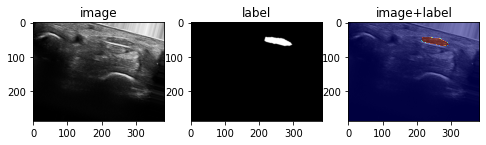

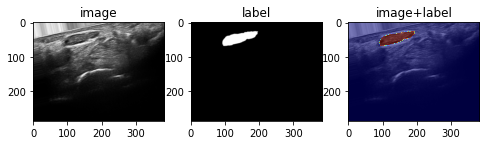

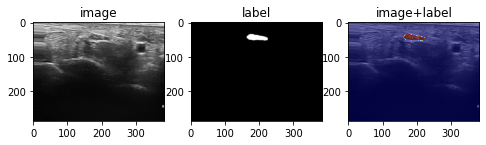

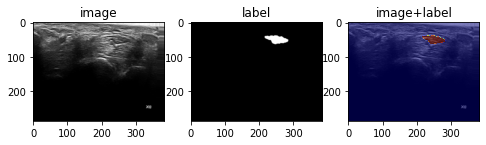

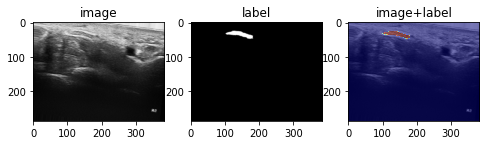

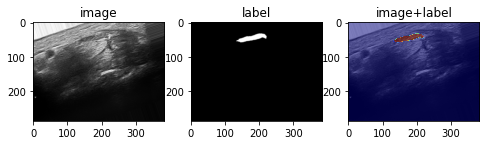

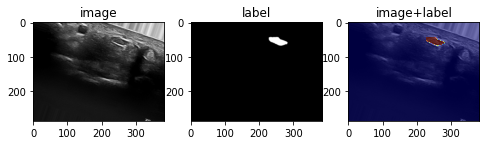

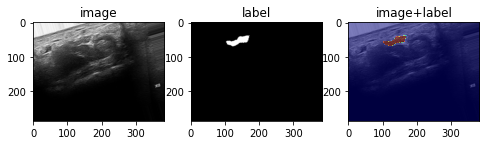

In [10]:
# DATA AUGMENTATION ============================================================
train_generator, val_generator = lib.data_augmentation(seed, dataset_list, params)

params["length_training"]   = len(dataset_list[0]['train'])
params['length_validation'] = len(dataset_list[0]['validation'])

augmented_batch_plot = plots.plot_augmented_batch(train_generator)
plt.show()

In [11]:
print(params["length_training"])
print(params['length_validation'])
print(len(dataset_list[0]['test']))

164
38
44


# Models

In [12]:
from tensorflow import keras

loss      = metrics.bce_dice_loss
recall    = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
metric    = [metrics.dice, metrics.iou, recall, precision]

c_objects = {
    "bce_dice_loss": metrics.bce_dice_loss,
    "dice": metrics.dice,
    "iou": metrics.iou,
    "precision": tf.keras.metrics.Precision(),
    "recall": tf.keras.metrics.Recall(),
}

path_trained_models = '/content/drive/MyDrive/CVDL/trained_models/'

path_unet = 'unet'
path_lunet = 'lunet'
path_dblunet = 'dblunet'
path_dblunet_16 = 'dblunet_vgg16'
path_dbunet = 'dbunet'

model_unet = keras.models.load_model(f'{path_trained_models}/{path_unet}/model.h5', custom_objects=c_objects)
model_lunet = keras.models.load_model(f'{path_trained_models}/{path_lunet}/model.h5', custom_objects=c_objects)
model_dblunet_16 = keras.models.load_model('/content/drive/MyDrive/CVDL/trained_models/dbunet_BN_vgg16_lr0.001_prenderequesto/model.hdf5', custom_objects=c_objects)
model_dblunet = keras.models.load_model(f'{path_trained_models}/{path_dblunet}/model.h5', custom_objects=c_objects)
model_dbunet = keras.models.load_model(f'/content/drive/MyDrive/CVDL/trained_models/doubleunet_original_d0.8995/model.h5', custom_objects=c_objects)

model_unet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model_lunet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model_dblunet_16.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model_dblunet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)
model_dbunet.compile(loss=metrics.bce_dice_loss, optimizer='adam', metrics=metric)

history_unet = pickle.load(open( f"{path_trained_models}/{path_unet}/train_history", "rb" ))
history_lunet = pickle.load(open( f"{path_trained_models}/{path_lunet}/train_history", "rb" ))
history_dblunet_16 = pickle.load(open( "/content/drive/MyDrive/CVDL/trained_models/dbunet_BN_vgg16_lr0.001_prenderequesto/train_history", "rb" ))
history_dblunet = pickle.load(open( f"{path_trained_models}/{path_dblunet}/train_history", "rb" ))
history_dbunet = pickle.load(open( f"/content/drive/MyDrive/CVDL/trained_models/doubleunet_original_d0.8995/train_history", "rb" ))


# Evaluate

### Unet

        dice
0   0.792743
1   0.853874
2   0.761636
3   0.922314
4   0.937095
5   0.904398
6   0.834879
7   0.935678
8   0.922509
9   0.912141
10  0.747493
11  0.907397
12  0.922655
13  0.612403
14  0.773510
15  0.915663
16  0.822447
17  0.375000
18  0.872423
19  0.765565
20  0.819530
21  0.776632
22  0.933411
23  0.936954
24  0.876404
25  0.935504
26  0.880952
27  0.929388
28  0.768473
29  0.938381
30  0.731587
31  0.735733
32  0.874661
33  0.915751
34  0.883203
35  0.858271
36  0.924606
37  0.822718
38  0.878822
39  0.749004
40  0.937649
41  0.906338
42  0.677091
43  0.745136
Average dice: count    43.000000
mean      0.850070
std       0.083163
min       0.612403
25%       0.775071
50%       0.876404
75%       0.922412
max       0.938381
Name: dice, dtype: float64
     dice
17  0.375
Ratio: 0.022727272727272728




Image index 17 - dice: dice    0.375
Name: 17, dtype: float64


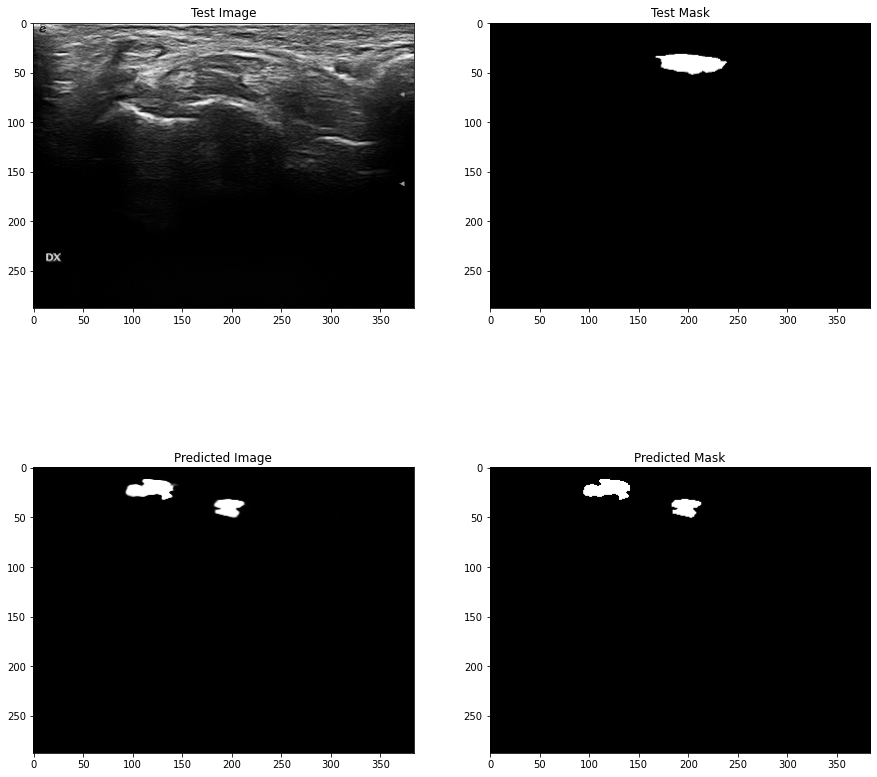

In [13]:
restults_df_unet = lib.evaluate(dataset_list, model_unet, params)
bad_pred_unet    = lib.get_bad_pred(restults_df_unet)
plots.plot_bad_predictions(bad_pred_unet, dataset_list, params, model_unet)

### Lightweight Unet

In [14]:
restults_df_lunet = lib.evaluate(dataset_list, model_lunet, params)
bad_pred_lunet    = lib.get_bad_pred(restults_df_lunet)
plots.plot_bad_predictions(bad_pred_lunet, dataset_list, params, model_lunet)

        dice
0   0.695327
1   0.776329
2   0.908989
3   0.897252
4   0.918621
5   0.903818
6   0.878073
7   0.824700
8   0.914986
9   0.934274
10  0.663591
11  0.804945
12  0.918446
13  0.640575
14  0.931378
15  0.913124
16  0.938776
17  0.704264
18  0.888889
19  0.664425
20  0.900249
21  0.873501
22  0.913844
23  0.925234
24  0.846507
25  0.918433
26  0.922061
27  0.903014
28  0.613169
29  0.925114
30  0.836619
31  0.935009
32  0.655621
33  0.933845
34  0.832255
35  0.718497
36  0.769124
37  0.777939
38  0.886937
39  0.753853
40  0.896477
41  0.899679
42  0.814414
43  0.827518
Average dice: count    44.000000
mean      0.840902
std       0.096279
min       0.613169
25%       0.777537
50%       0.887913
75%       0.915848
max       0.938776
Name: dice, dtype: float64
Empty DataFrame
Columns: [dice]
Index: []
Ratio: 0.0


### Double LUnet

In [15]:
restults_df_dlunet = lib.evaluate(dataset_list, model_dblunet, params)
bad_pred_dlunet    = lib.get_bad_pred(restults_df_dlunet)
plots.plot_bad_predictions(bad_pred_dlunet, dataset_list, params, model_dblunet)

        dice
0   0.860024
1   0.925186
2   0.930312
3   0.913642
4   0.945693
5   0.945473
6   0.913196
7   0.908168
8   0.938356
9   0.937937
10  0.937313
11  0.904893
12  0.926339
13  0.908891
14  0.950678
15  0.935342
16  0.928763
17  0.941118
18  0.879325
19  0.814163
20  0.898998
21  0.924149
22  0.944255
23  0.959441
24  0.932267
25  0.936741
26  0.928105
27  0.923182
28  0.907796
29  0.932954
30  0.812667
31  0.956646
32  0.705882
33  0.943216
34  0.880884
35  0.947687
36  0.926745
37  0.893691
38  0.904203
39  0.825234
40  0.905782
41  0.906819
42  0.799389
43  0.677693
Average dice: count    44.000000
mean      0.902710
std       0.060346
min       0.677693
25%       0.902902
50%       0.924667
75%       0.937469
max       0.959441
Name: dice, dtype: float64
Empty DataFrame
Columns: [dice]
Index: []
Ratio: 0.0


In [16]:
'''
restults_df_dlunet_16 = lib.evaluate(dataset_list, model_dblunet_16, params)
bad_pred_dlunet_16    = lib.get_bad_pred(restults_df_dlunet_16)
plots.plot_bad_predictions(bad_pred_dlunet_16, dataset_list, params, model_dblunet_16)
'''

restults_df_dlunet_16 = lib.evaluate(dataset_list, model_dblunet_16, params)
bad_pred_dlunet_16 = lib.get_bad_pred(restults_df_dlunet_16)
#plots.plot_bad_predictions(bad_pred_dlunet_16, dataset_list, params, model_dblunet_16)

        dice
0   0.750341
1   0.924043
2   0.928261
3   0.942247
4   0.904741
5   0.903257
6   0.874023
7   0.910211
8   0.882306
9   0.923648
10  0.906593
11  0.922085
12  0.911445
13  0.883185
14  0.930208
15  0.914842
16  0.914926
17  0.934029
18  0.874965
19  0.849300
20  0.932846
21  0.856924
22  0.933794
23  0.954254
24  0.940682
25  0.918433
26  0.926671
27  0.912688
28  0.885116
29  0.907478
30  0.896386
31  0.952279
32  0.812125
33  0.762483
34  0.374023
35  0.874400
36  0.901744
37  0.836520
38  0.901902
39  0.823805
40  0.940293
41  0.924347
42  0.826307
43  0.515882
Average dice: count    42.000000
mean      0.895384
std       0.047032
min       0.750341
25%       0.876801
50%       0.908845
75%       0.926090
max       0.954254
Name: dice, dtype: float64
        dice
34  0.374023
43  0.515882
Ratio: 0.045454545454545456


##dbunet

        dice
0   0.917609
1   0.904255
2   0.895022
3   0.928719
4   0.953125
5   0.926089
6   0.869767
7   0.929615
8   0.910454
9   0.939108
10  0.953271
11  0.922246
12  0.920738
13  0.643930
14  0.953108
15  0.953710
16  0.936517
17  0.919272
18  0.880987
19  0.799924
20  0.942946
21  0.882306
22  0.936009
23  0.956402
24  0.937848
25  0.935298
26  0.923584
27  0.934326
28  0.749452
29  0.892919
30  0.924232
31  0.921013
32  0.132336
33  0.941631
34  0.875153
35  0.917882
36  0.926236
37  0.913947
38  0.901333
39  0.874832
40  0.912429
41  0.908708
42  0.750381
43  0.764461
Average dice: count    43.000000
mean      0.899553
std       0.064585
min       0.643930
25%       0.893970
50%       0.920738
75%       0.935653
max       0.956402
Name: dice, dtype: float64
        dice
32  0.132336
Ratio: 0.022727272727272728




Image index 32 - dice: dice    0.132336
Name: 32, dtype: float64


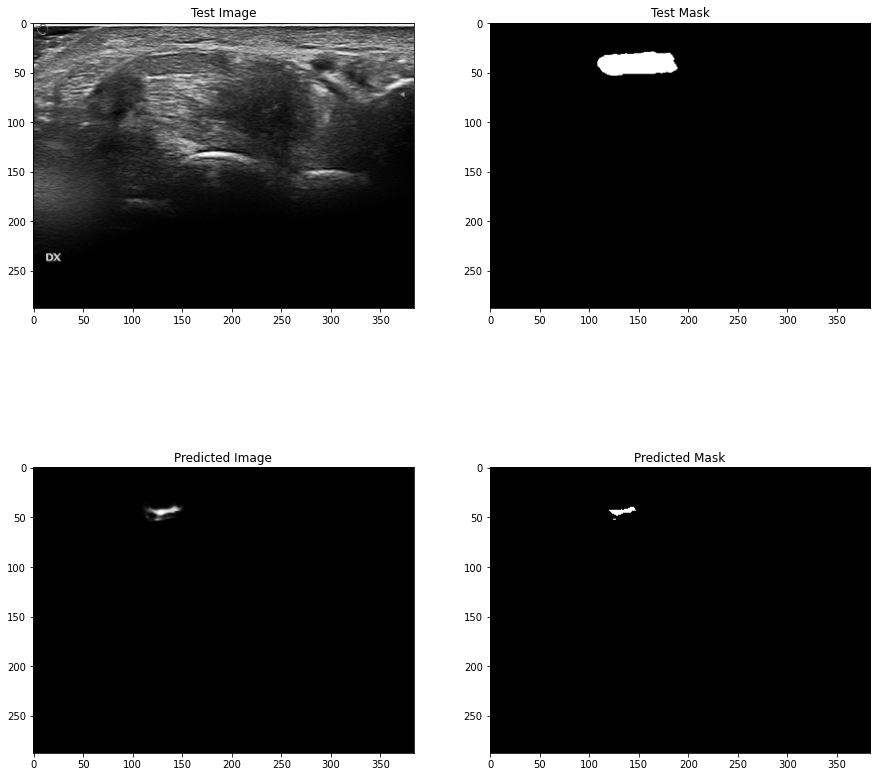

In [17]:
restults_df_dbunet = lib.evaluate(dataset_list, model_dbunet, params)
bad_pred_dbunet = lib.get_bad_pred(restults_df_dbunet)
plots.plot_bad_predictions(bad_pred_dbunet, dataset_list, params, model_dbunet)

# Test Images

## Preprocessing

In [29]:
def test_plot(image_index, threshold, dataset_list, mode):
  test_image  = dataset_list[0][mode][image_index,:,:,0]
  test_mask   = dataset_list[1][mode][image_index,:,:,0]

  test_results_unet   = lib.get_preditcions(test_image, test_mask, params, model_unet, threshold)
  test_results_lnuet  = lib.get_preditcions(test_image, test_mask, params, model_lunet, threshold)
  test_results_dlunet = lib.get_preditcions(test_image, test_mask, params, model_dblunet, threshold)
  test_results_dbunet = lib.get_preditcions(test_image, test_mask, params, model_dbunet, threshold)

  results_figure = plot_test_results(test_image, test_mask, test_results_unet, test_results_lnuet, test_results_dbunet, test_results_dlunet)
  plt.show()

def plot_test_results(test_image, test_mask, ts_1, ts_2, ts_3, ts_4):

  fig_1, ax_1 = plt.subplots(2, 1, figsize=(12,12))
  #ax_1[0].set_title('Test Image')
  ax_1[0].imshow(test_image, cmap='gray')
  #ax_1[1].set_title('Test Image + Label')
  ax_1[1].imshow(test_image, cmap='gray')
  ax_1[1].imshow(test_mask, 'jet', interpolation='none', alpha=0.5)
  ax_1[0].axis('off')
  ax_1[1].axis('off')
  #plt.show()

  fig, ax = plt.subplots(4, 3, figsize=(16,16))
  #ax[0,0].set_title('Test Mask')
  ax[0,0].imshow(ts_1['test_mask'], cmap='gray')
  #ax[0,1].set_title('Predicted Mask Unet')
  ax[0,1].imshow(ts_1['pred_mask'], cmap='gray')
  #ax[0,2].set_title('Diff Mask')
  dif_1 = ts_1['test_mask'] - ts_1['pred_mask']
  ax[0,2].imshow(dif_1, cmap='gray')

  #ax[1,0].set_title('Test Mask')
  ax[1,0].imshow(ts_2['test_mask'], cmap='gray')
  #ax[1,1].set_title('Predicted Mask L-Unet')
  ax[1,1].imshow(ts_2['pred_mask'], cmap='gray')
  #ax[1,2].set_title('Diff Mask')
  dif_2 = ts_2['test_mask'] - ts_2['pred_mask']
  ax[1,2].imshow(dif_2, cmap='gray')

  #ax[2,0].set_title('Test Mask')
  ax[2,0].imshow(ts_3['test_mask'], cmap='gray')
  #ax[2,1].set_title('Predicted Mask Double-Unet')
  ax[2,1].imshow(ts_3['pred_mask'], cmap='gray')
  #ax[2,2].set_title('Diff Mask')
  dif_3 = ts_3['test_mask'] - ts_3['pred_mask']
  ax[2,2].imshow(dif_3, cmap='gray')

  #ax[3,0].set_title('Test Mask')
  ax[3,0].imshow(ts_4['test_mask'], cmap='gray')
  #ax[3,1].set_title('Predicted Mask DL-Unet')
  ax[3,1].imshow(ts_4['pred_mask'], cmap='gray')
  #ax[3,2].set_title('Diff Mask')
  dif_4 = ts_4['test_mask'] - ts_4['pred_mask']
  ax[3,2].imshow(dif_4, cmap='gray')

  ax[0,0].axis('off')
  ax[0,1].axis('off')
  ax[0,2].axis('off')

  ax[1,0].axis('off')
  ax[1,1].axis('off')
  ax[1,2].axis('off')

  ax[2,0].axis('off')
  ax[2,1].axis('off')
  ax[2,2].axis('off')

  ax[3,0].axis('off')
  ax[3,1].axis('off')
  ax[3,2].axis('off')
  return fig


In [19]:
def test_plot_backbones(image_index, threshold, dataset_list, mode):
  test_image  = dataset_list[0][mode][image_index,:,:,0]
  test_mask   = dataset_list[1][mode][image_index,:,:,0]

  test_results_dlunet_16 = lib.get_preditcions(test_image, test_mask, params, model_dblunet_16, threshold)
  test_results_dlunet    = lib.get_preditcions(test_image, test_mask, params, model_dblunet, threshold)

  results_figure = plot_test_results_backbones(test_image, test_mask, test_results_dlunet_16, test_results_dlunet)
  plt.show()

def plot_test_results_backbones(test_image, test_mask, ts_1, ts_2):

  fig_1, ax_1 = plt.subplots(2, 1, figsize=(12,12))
  ax_1[0].set_title('Test Image')
  ax_1[0].imshow(test_image, cmap='gray')
  ax_1[1].set_title('Test Image + Label')
  ax_1[1].imshow(test_image, cmap='gray')
  ax_1[1].imshow(test_mask, 'jet', interpolation='none', alpha=0.5)
  #plt.show()

  fig, ax = plt.subplots(2, 3, figsize=(20,20))
  ax[0,0].set_title('Test Mask')
  ax[0,0].imshow(ts_1['test_mask'], cmap='gray')
  ax[0,1].set_title('Predicted Mask DL-Unet VGG16')
  ax[0,1].imshow(ts_1['pred_mask'], cmap='gray')
  ax[0,2].set_title('Diff Mask')
  dif_1 = ts_1['test_mask'] - ts_1['pred_mask']
  ax[0,2].imshow(dif_1, cmap='gray')

  ax[1,0].set_title('Test Mask')
  ax[1,0].imshow(ts_2['test_mask'], cmap='gray')
  ax[1,1].set_title('Predicted Mask DL-Unet VGG19')
  ax[1,1].imshow(ts_2['pred_mask'], cmap='gray')
  ax[1,2].set_title('Diff Mask')
  dif_2 = ts_2['test_mask'] - ts_2['pred_mask']
  ax[1,2].imshow(dif_2, cmap='gray')

  ax[0,0].axis('off')
  ax[0,1].axis('off')
  ax[0,2].axis('off')

  ax[1,0].axis('off')
  ax[1,1].axis('off')
  ax[1,2].axis('off')

  return fig


In [20]:
import pandas as pd
df = pd.DataFrame(list(zip(restults_df_unet.dice, restults_df_lunet.dice, restults_df_dbunet.dice, restults_df_dlunet_16.dice, restults_df_dlunet.dice)), columns =['Unet', 'L-Unet', 'DB-Unet', 'DL-Unet-16', 'DL-Unet'])

## Plot Result Merde

In [21]:
minvalue_series = df.min()
print(minvalue_series)
print('\n')
minvalueIndexLabel = df.idxmin() 
print(minvalueIndexLabel)

Unet          0.375000
L-Unet        0.613169
DB-Unet       0.132336
DL-Unet-16    0.374023
DL-Unet       0.677693
dtype: float64


Unet          17
L-Unet        28
DB-Unet       32
DL-Unet-16    34
DL-Unet       43
dtype: int64


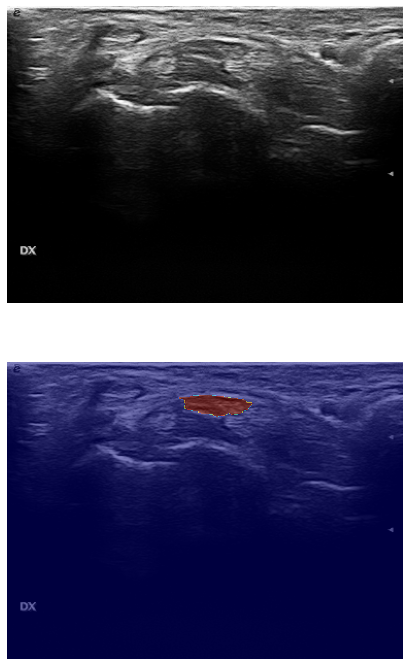

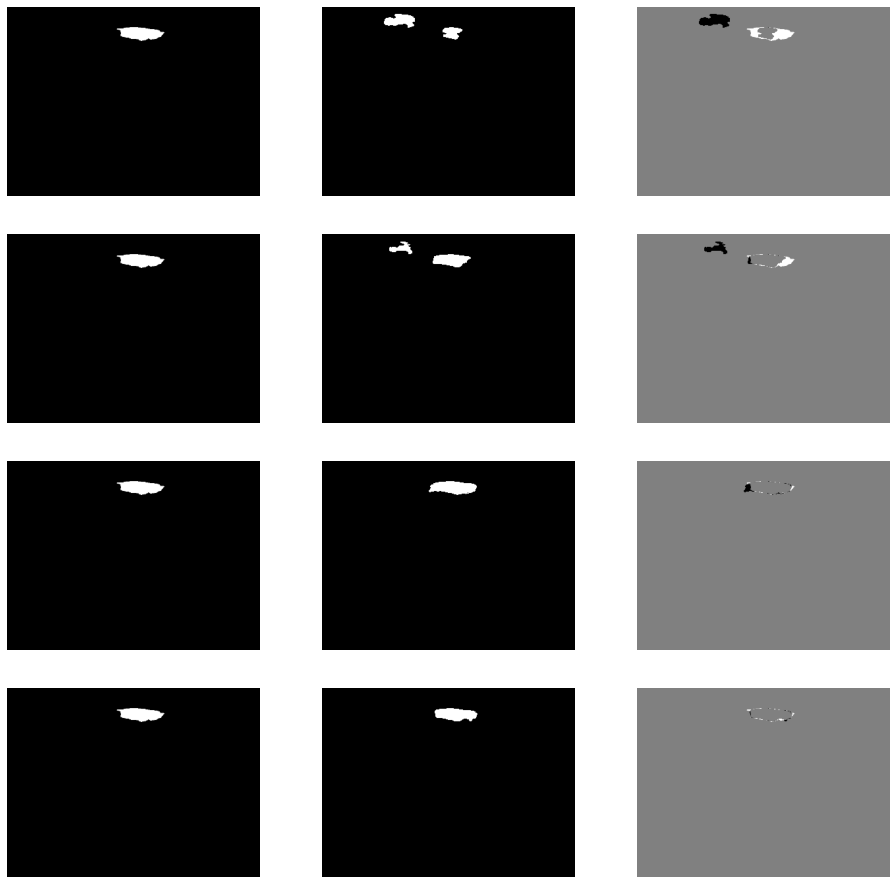

In [28]:
test_plot(minvalueIndexLabel['Unet'], 0.5, dataset_list, 'test')

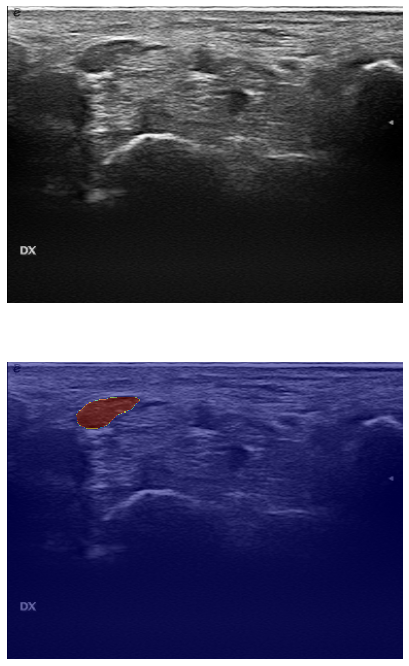

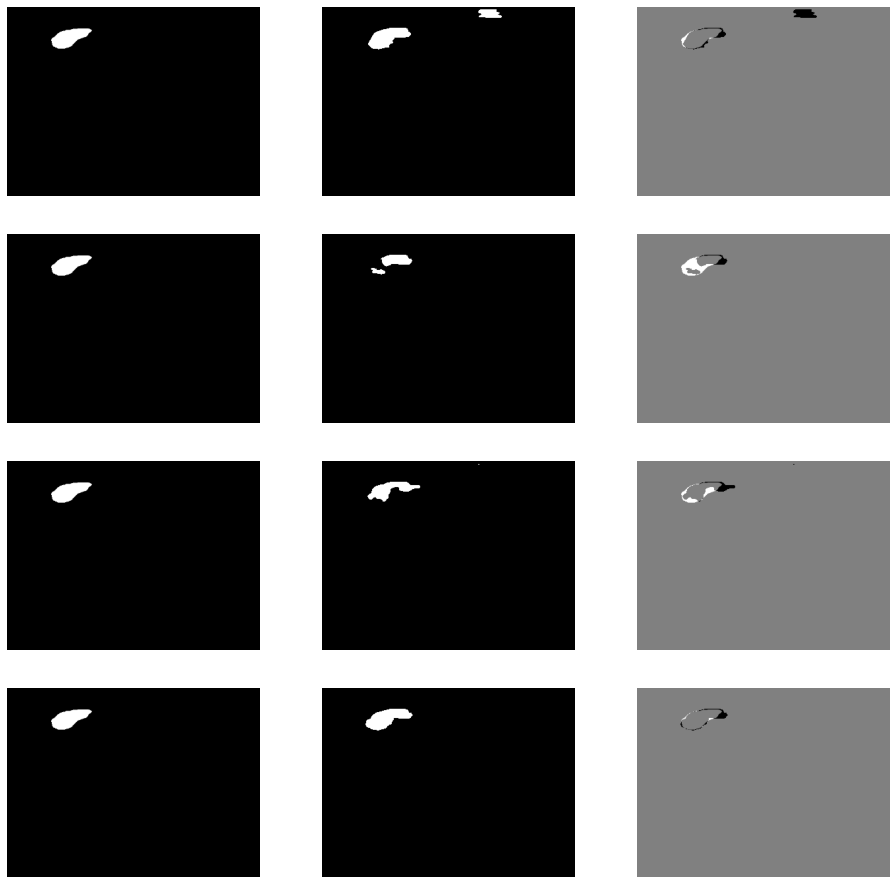

In [ ]:
test_plot(minvalueIndexLabel['L-Unet'], 0.5, dataset_list, 'test')

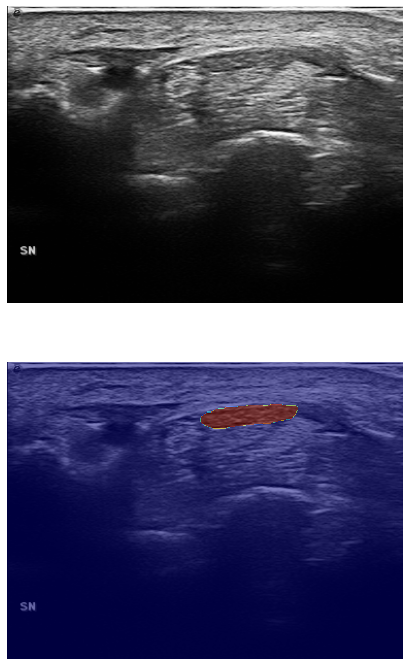

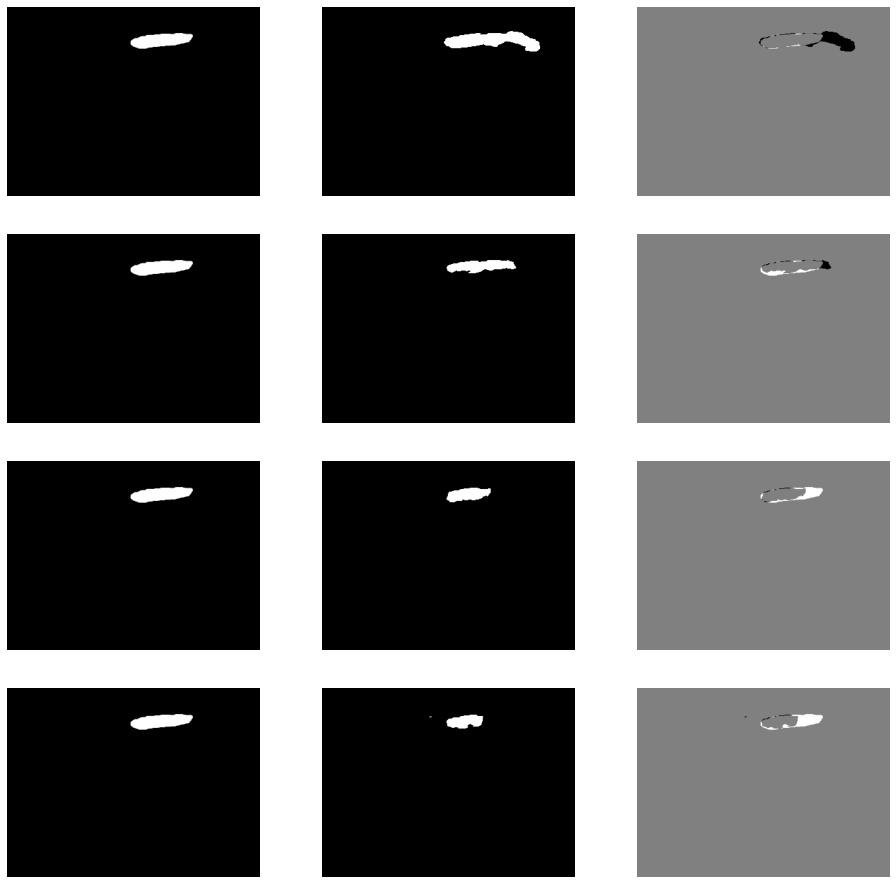

In [ ]:
test_plot(minvalueIndexLabel['DL-Unet'], 0.5, dataset_list, 'test')

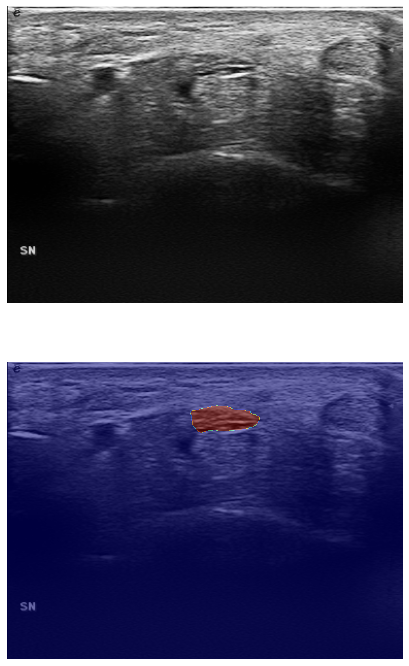

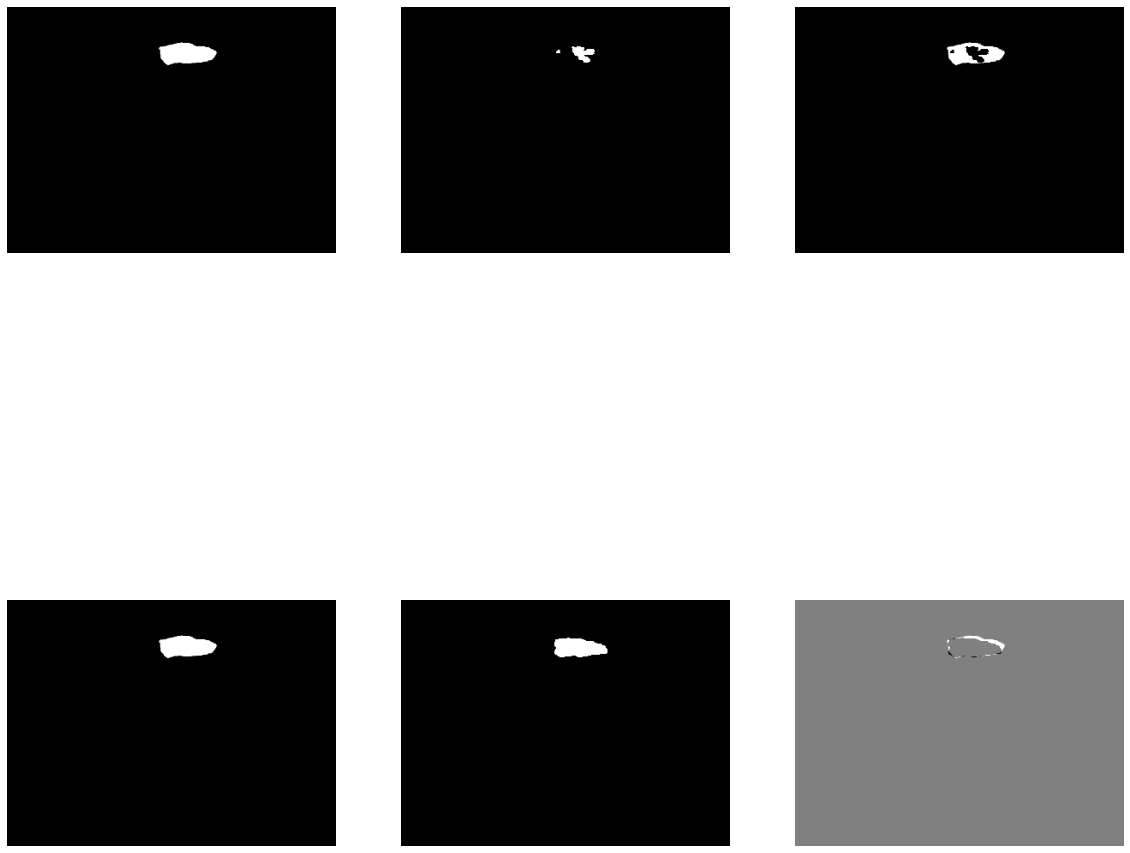

In [ ]:
test_plot_backbones(minvalueIndexLabel['DL-Unet-16'], 0.5, dataset_list, 'test')

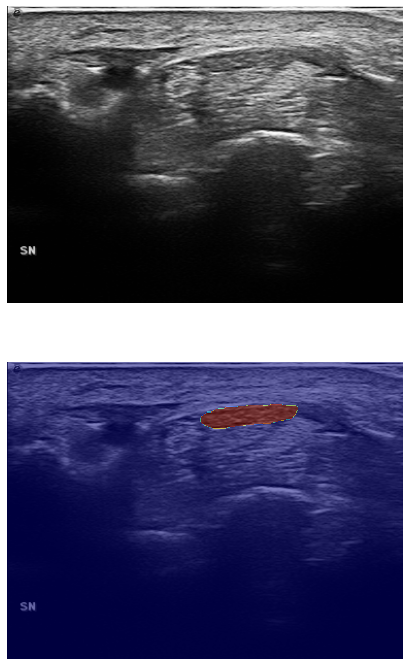

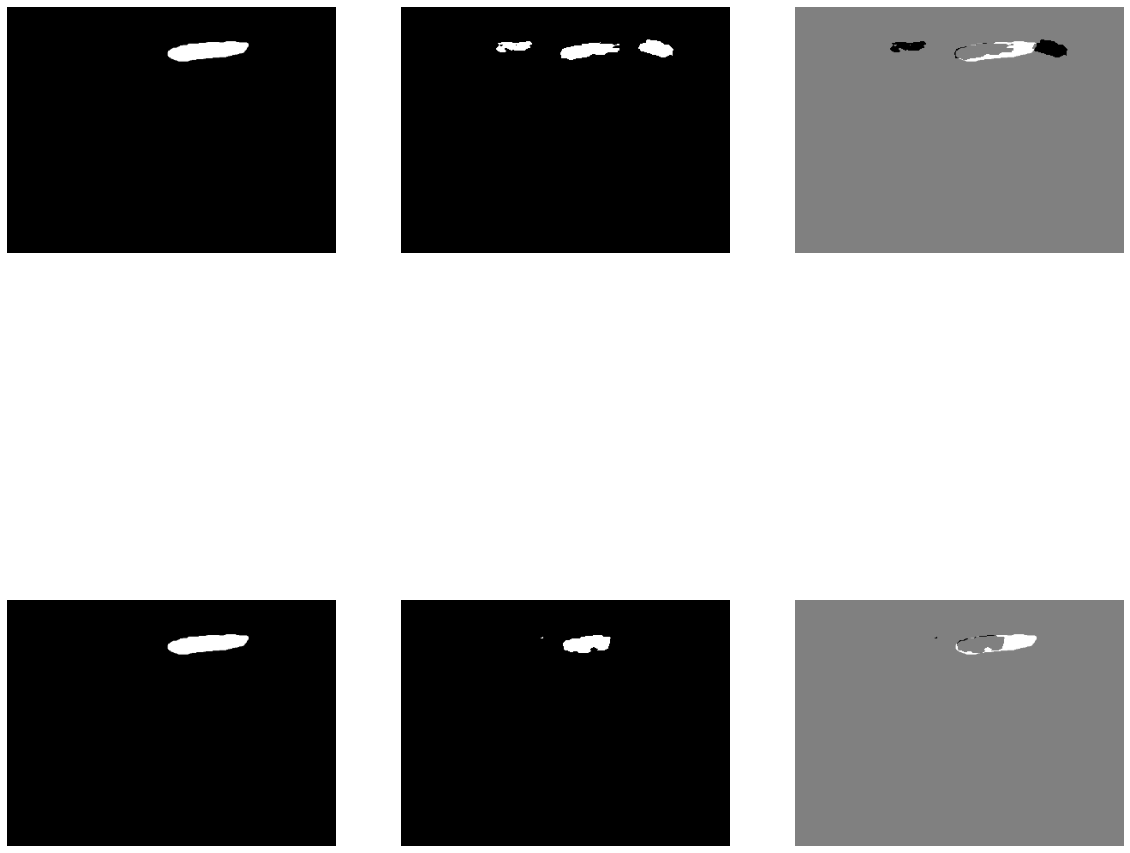

In [ ]:
test_plot_backbones(minvalueIndexLabel['DL-Unet'], 0.5, dataset_list, 'test')

## Plot result top

In [ ]:
maxvalue_series = df.max()
print(maxvalue_series)
print('\n')
maxvalueIndexLabel = df.idxmax() 
print(maxvalueIndexLabel)

Unet          0.938381
L-Unet        0.938776
DB-Unet       0.956402
DL-Unet-16    0.954254
DL-Unet       0.959441
dtype: float64


Unet          29
L-Unet        16
DB-Unet       23
DL-Unet-16    23
DL-Unet       23
dtype: int64


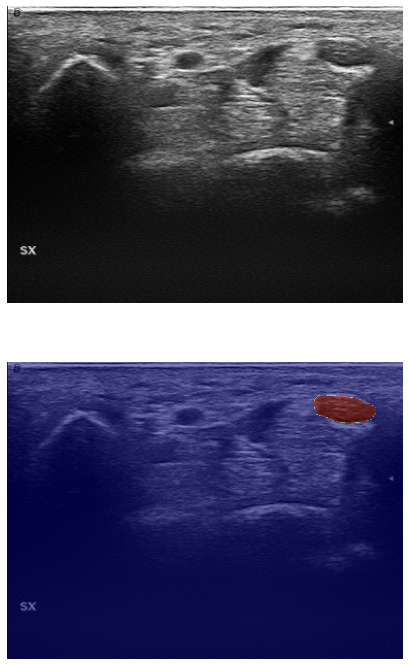

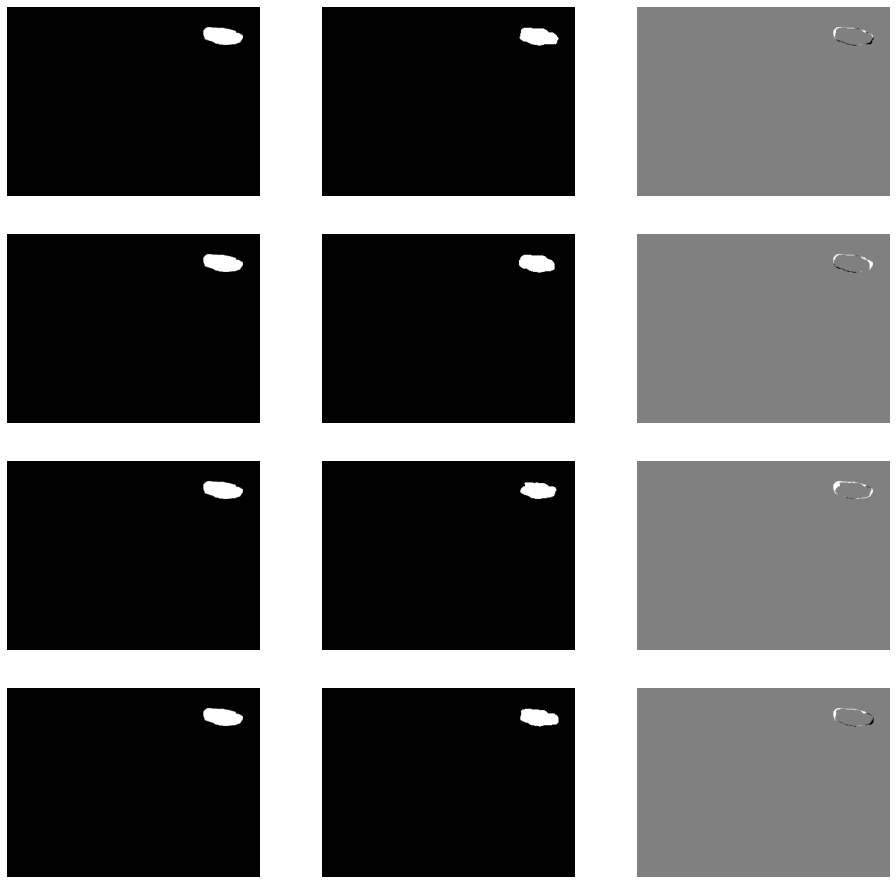

In [ ]:
test_plot(maxvalueIndexLabel['Unet'], 0.5, dataset_list, 'test')

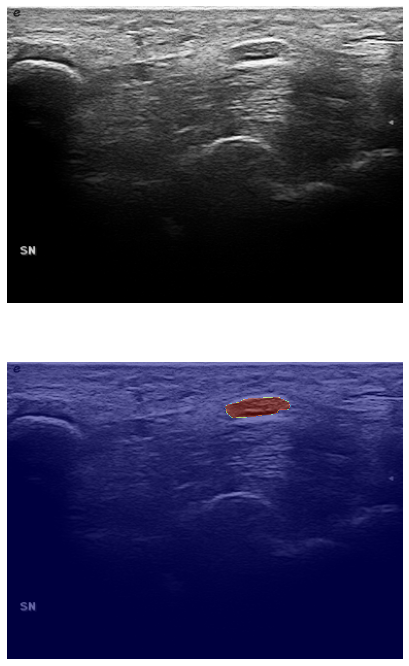

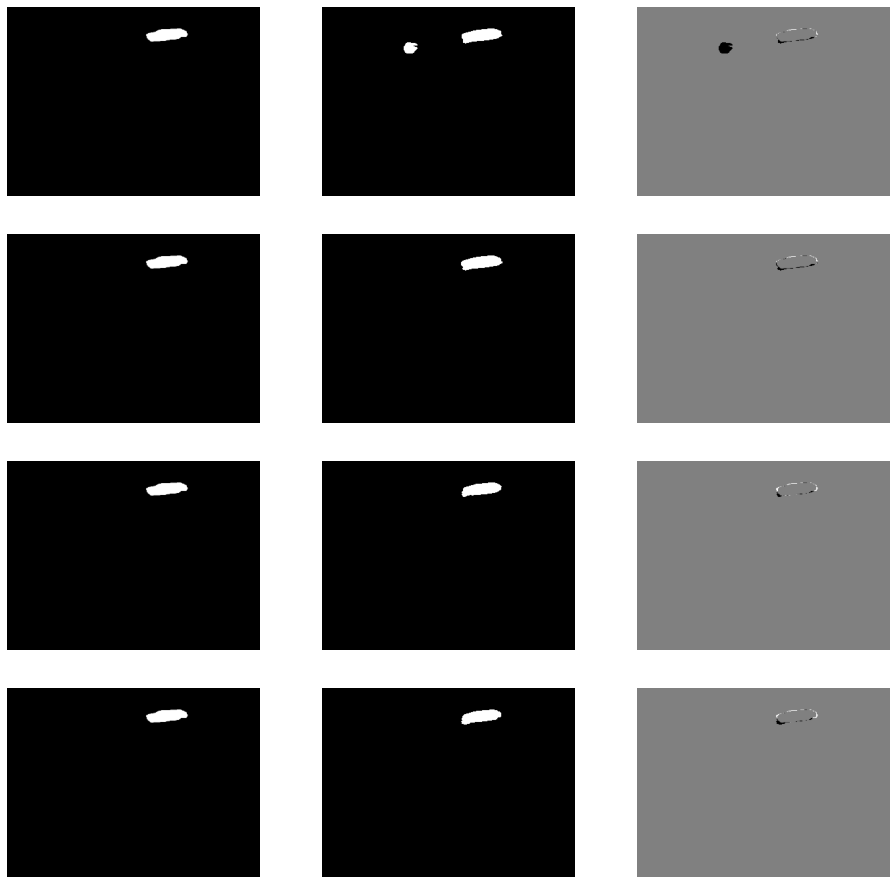

In [ ]:
test_plot(maxvalueIndexLabel['L-Unet'], 0.5, dataset_list, 'test')

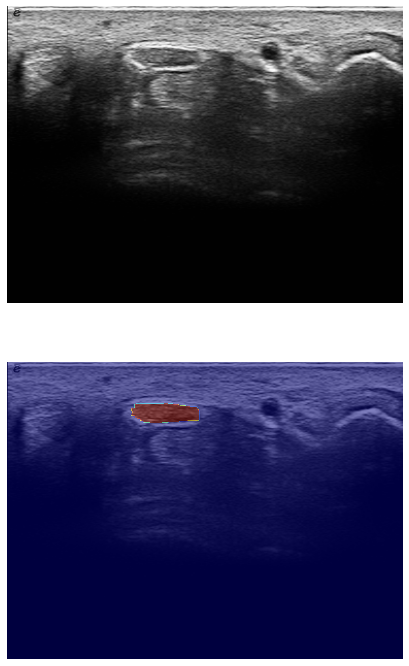

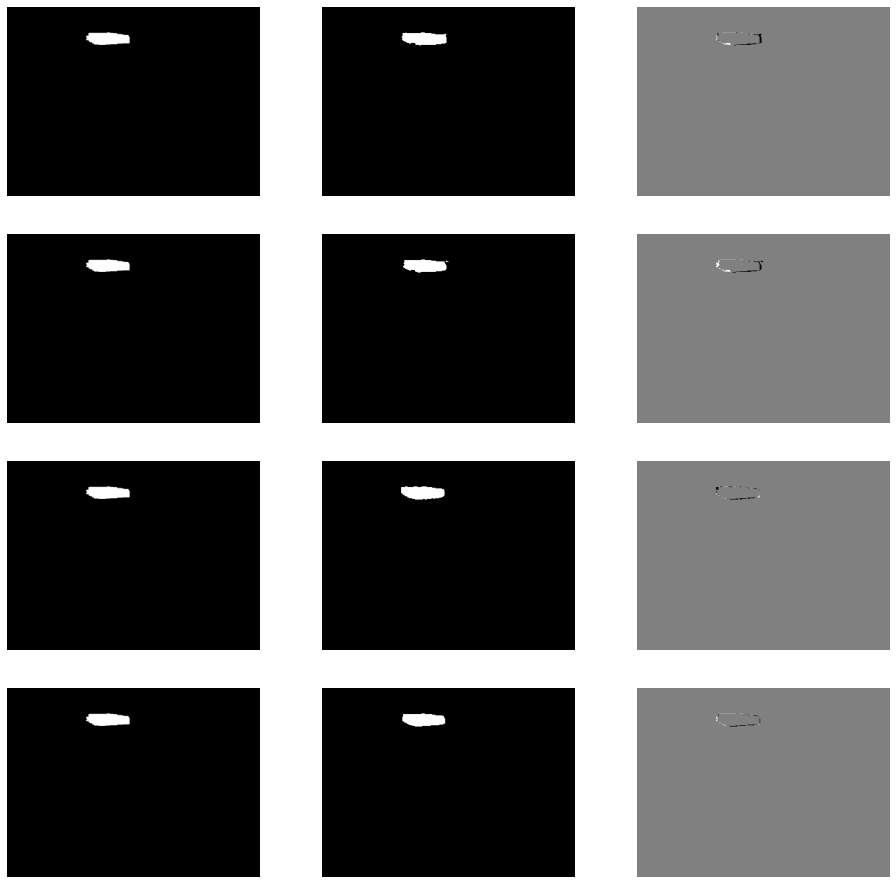

In [ ]:
test_plot(maxvalueIndexLabel['DL-Unet'], 0.5, dataset_list, 'test')

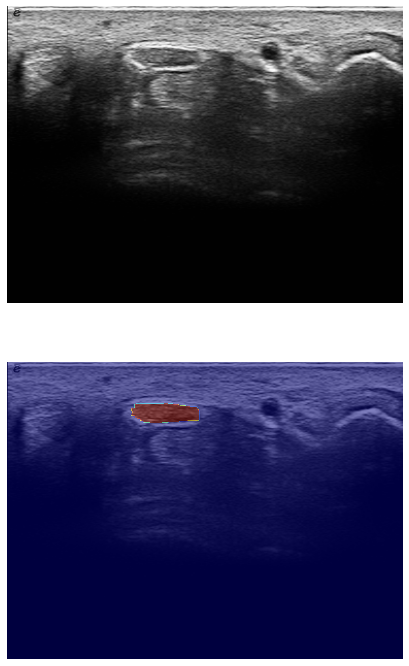

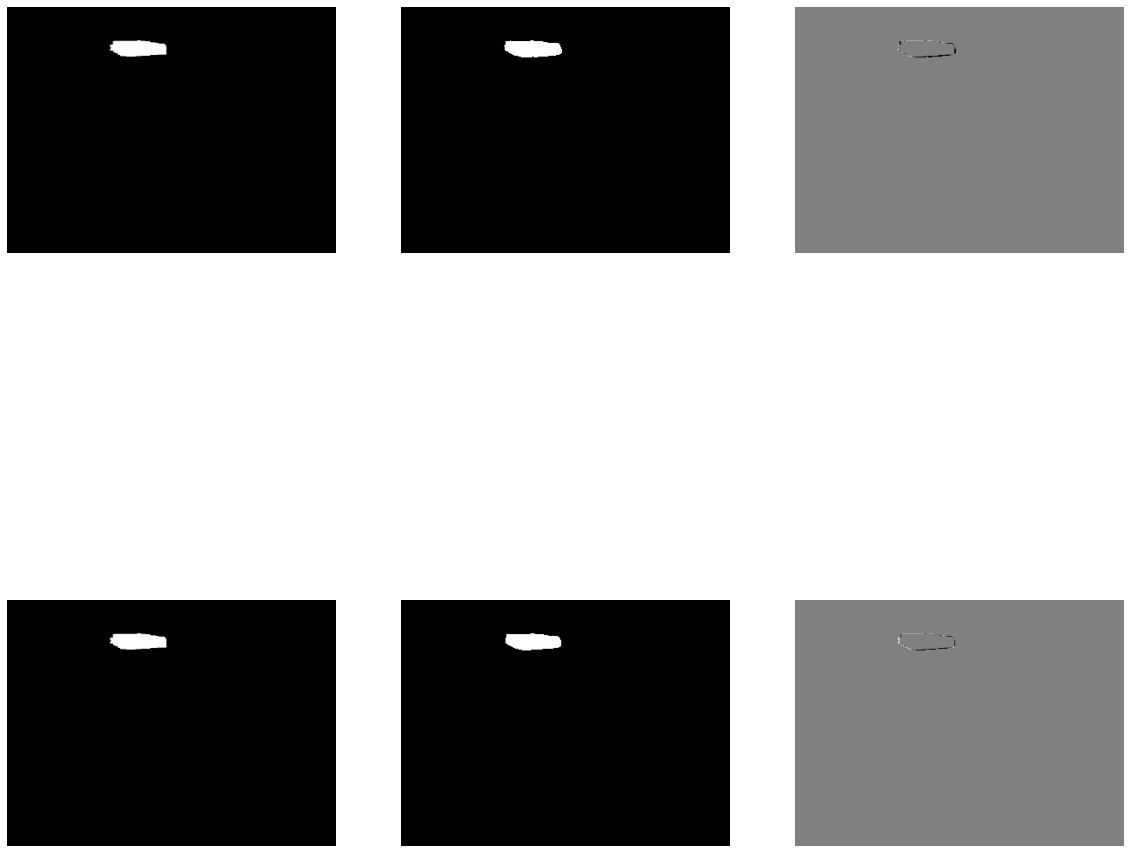

In [ ]:
test_plot_backbones(maxvalueIndexLabel['DL-Unet-16'], 0.5, dataset_list, 'test')

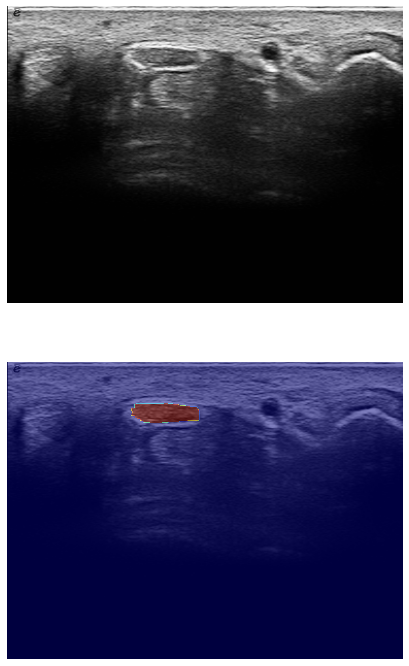

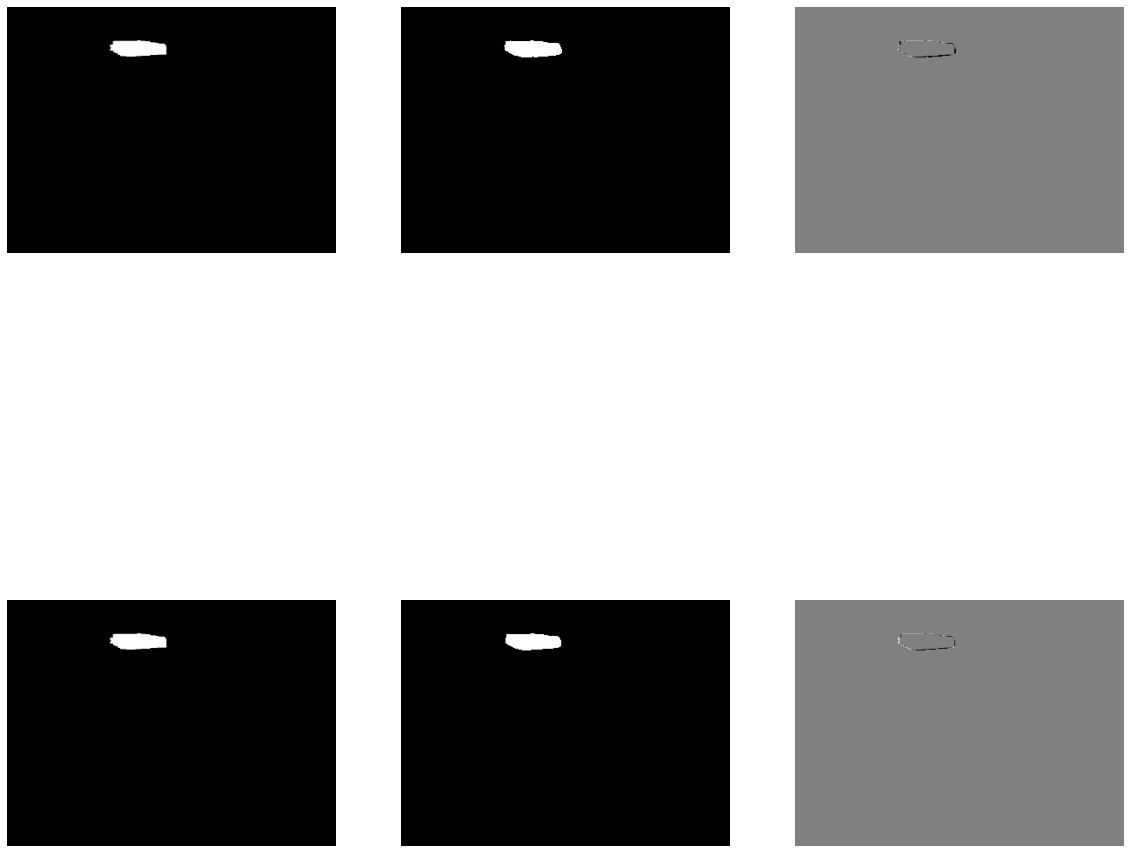

In [ ]:
test_plot_backbones(maxvalueIndexLabel['DL-Unet'], 0.5, dataset_list, 'test')

## prova

In [ ]:
mode = modality[1]
for i in range(len(dataset_list[0][mode])):
  test_image  = dataset_list[0][mode][i,:,:,0]
  test_mask   = dataset_list[1][mode][i,:,:,0]
  fig, ax = plt.subplots(1, 2, figsize=(8,8))
  ax[0].set_title(f'Test Image_{i}')
  ax[0].imshow(test_image, cmap='gray')
  ax[1].set_title('Test Image + Label')
  ax[1].imshow(test_image, cmap='gray')
  ax[1].imshow(test_mask, 'jet', interpolation='none', alpha=0.5)

  plt.show()

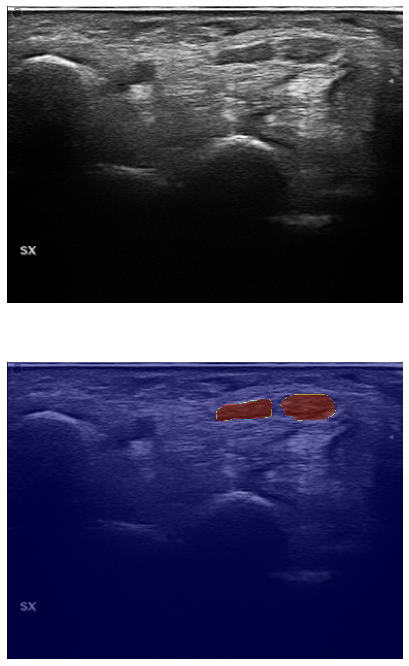

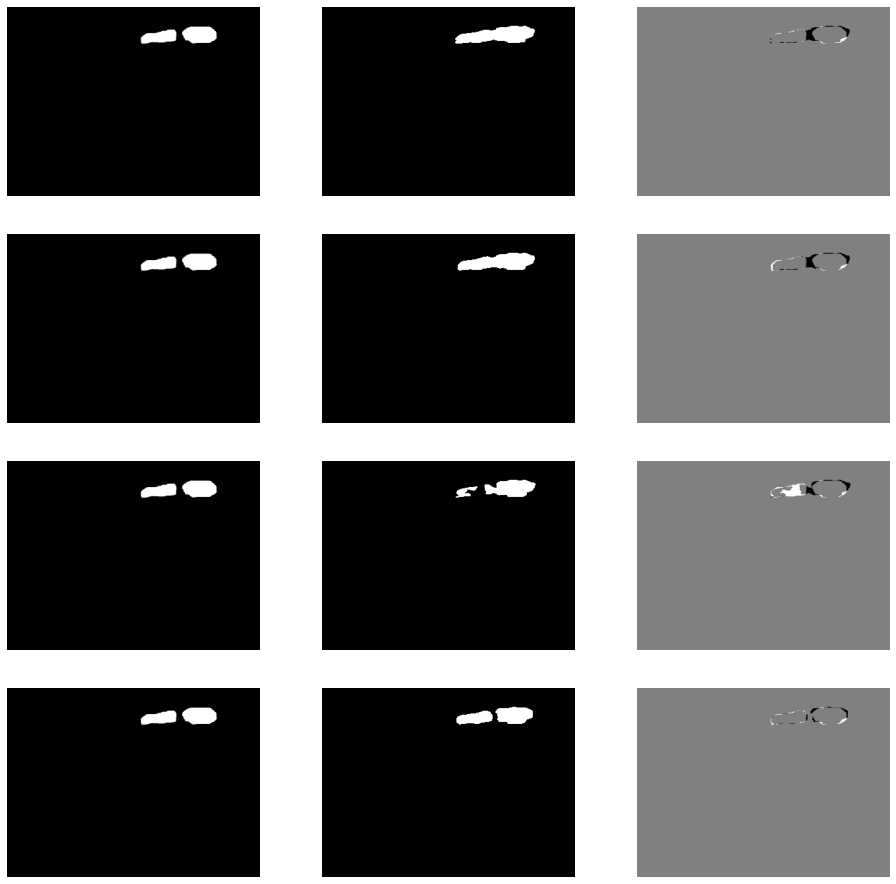

In [ ]:
test_plot(16, 0.5, dataset_list, 'validation')

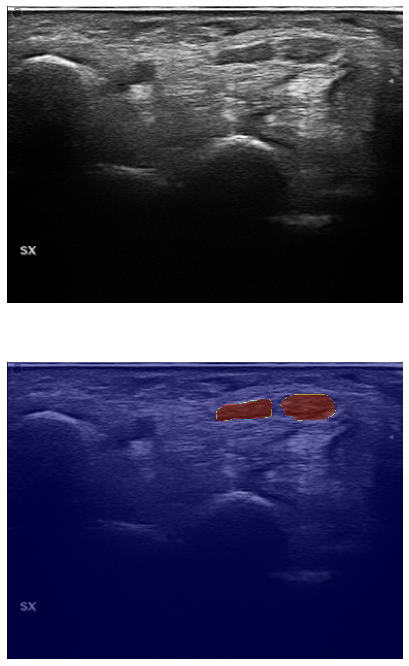

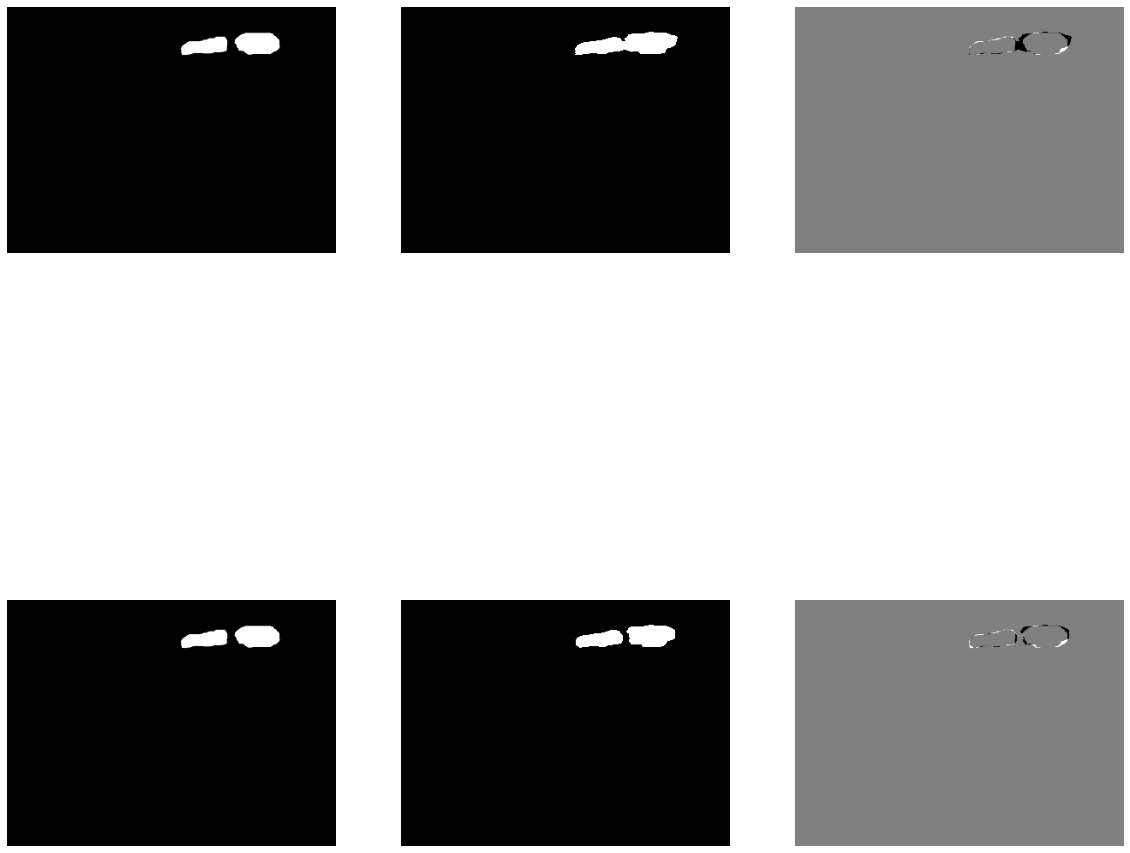

In [ ]:
test_plot_backbones(16, 0.5, dataset_list, 'validation')

# Plots

### Unet

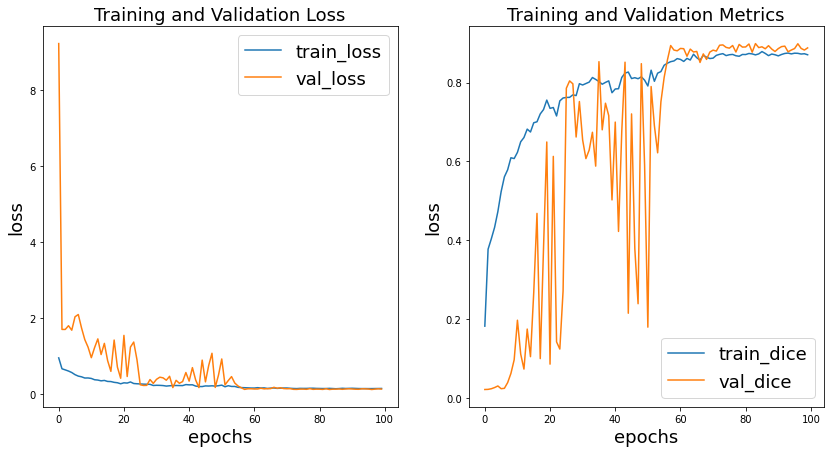

In [ ]:
# Unet
plots.plot_train_metric(history_unet, params['nEpoches'], "dice")
plt.show()

### Lightweight Unet

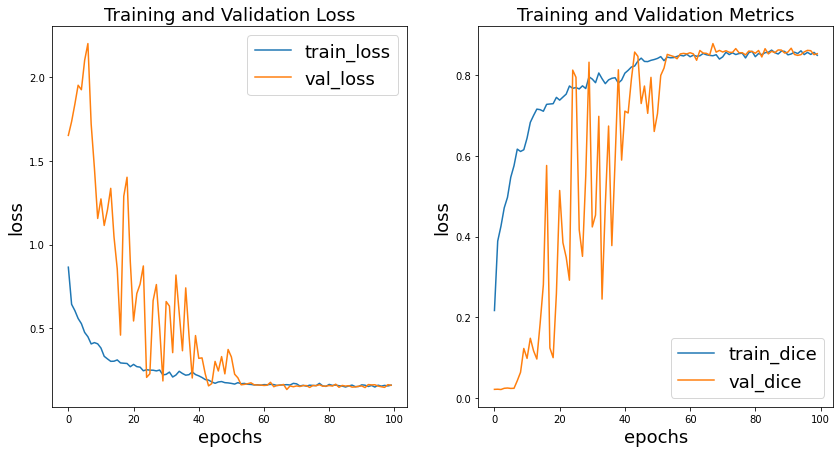

In [ ]:
# LUnet
plots.plot_train_metric(history_lunet, params['nEpoches'], "dice")
plt.show()

### Double LUnet

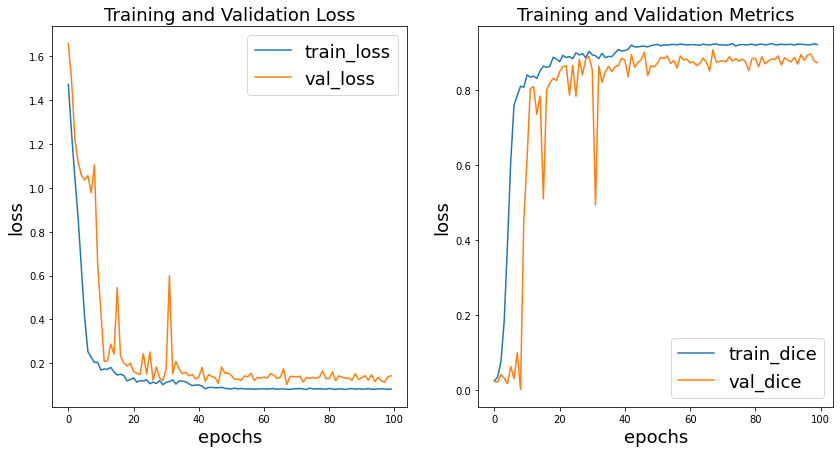

In [ ]:
# DBLUnet
plots.plot_train_metric(history_dblunet, params['nEpoches'], "dice")
plt.show()

##DUnet

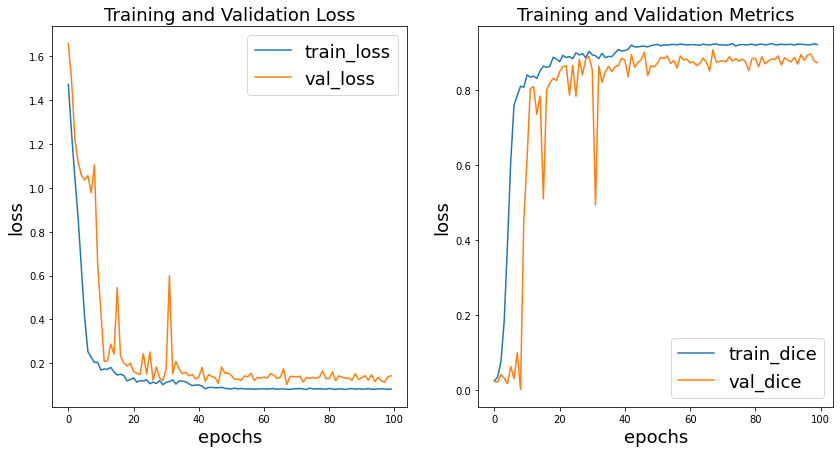

In [ ]:
plots.plot_train_metric(history_dblunet, params['nEpoches'], "dice")
plt.show()